In [414]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

#evaluation metrics
from sklearn.metrics import mean_squared_error

#stationarity assumption
from statsmodels.tsa.stattools import adfuller

#trend analysis
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

In [72]:
pwd

'C:\\Users\\Sam Cannon\\Desktop\\Python\\Springboard\\Data Science Career Track\\Capstone 1\\seattle_police'

In [4]:
os.chdir('C:\\Users\\Sam Cannon\\Desktop\\Python\\Springboard\\Data Science Career Track\\Capstone 1\\seattle_police')

In [377]:
#read in data, attempt to parse the call time date features
df = pd.read_csv('Call_Data.csv', parse_dates = [6, 7])

In [379]:
#look at some descriptive info for our dataset, looks like the date parser was unable to parse arrived_time, so I will parse that next
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170107 entries, 0 to 4170106
Data columns (total 11 columns):
CAD Event Number               int64
Event Clearance Description    object
Call Type                      object
Priority                       int64
Initial Call Type              object
Final Call Type                object
Original Time Queued           datetime64[ns]
Arrived Time                   object
Precinct                       object
Sector                         object
Beat                           object
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 350.0+ MB


In [380]:
#create datetime object from arrived time
df['Arrived Time'] = [datetime.strptime(x, "%b %d %Y %I:%M:%S:%f%p") for x in df['Arrived Time']]

In [381]:
#now I want to lowercase the entire dataframe so that there arent any capitalization error issues
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [382]:
#now I want to lowercase the columns and replace spaces with _
df.columns = [c.lower() for c in df.columns]
df.columns = [c.replace(' ', '_') for c in df.columns]

In [383]:
#now I want to look at the head of my data to make sure the changes look right
df.head(1)

,cad_event_number,event_clearance_description,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat
0,2009000189335,evidence submitted (new incident number required),"telephone other, not 911",1,dist - ip/jo - dv dist - no aslt,"--dv - arguments, disturbance (no arrest)",2009-06-02 03:35:46,2009-06-02 04:09:38,east,charlie,c1


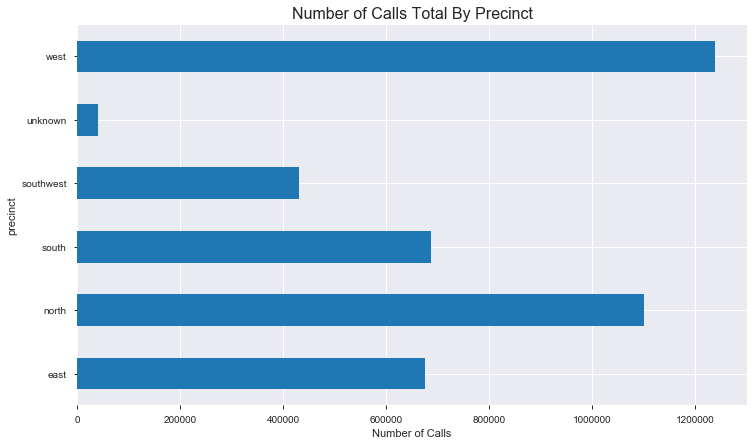

In [18]:
#how many calls are each precinct receiving in total?
df.groupby('precinct').cad_event_number.size().plot(kind = 'barh', figsize = (12, 7))
plt.title('Number of Calls Total By Precinct', fontsize = 16)
plt.xlabel('Number of Calls');

In [384]:
#I want to start with the precinct that had the most calls, so I will only be looking at data from the West precinct first
west = df[df['precinct'] == 'west']

#how much data do we have in this df?
west.shape

(1238467, 11)

In [385]:
#how many sectors and beats are in this precinct?
west.groupby(['sector', 'beat']).size()

sector  beat
david   d1      103990
        d2      116647
        d3       88081
king    k1       98693
        k2      112106
        k3      142091
mary    inv          1
        m1      103760
        m2      103996
        m3      143499
queen   q1       52862
        q2       76240
        q3       96501
dtype: int64

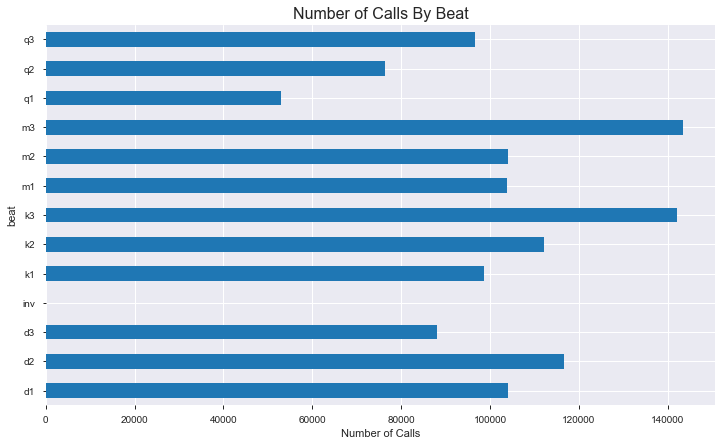

In [28]:
#plot this out to make it more interpretatble
west.groupby('beat').size().plot(kind = 'barh', figsize = (12, 7))
plt.title('Number of Calls By Beat', fontsize = 16)
plt.xlabel('Number of Calls');

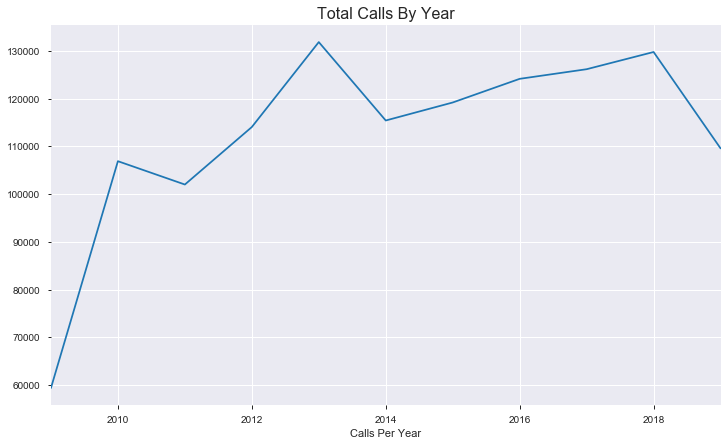

In [40]:
#looks like overall, the m3 and k3 beats have the most crimes being reported, what does call volume look like over time?
west.groupby(west['original_time_queued'].dt.year).size().plot(figsize = (12, 7))
plt.title('Total Calls By Year', fontsize = 16)
plt.xlabel('Calls Per Year');

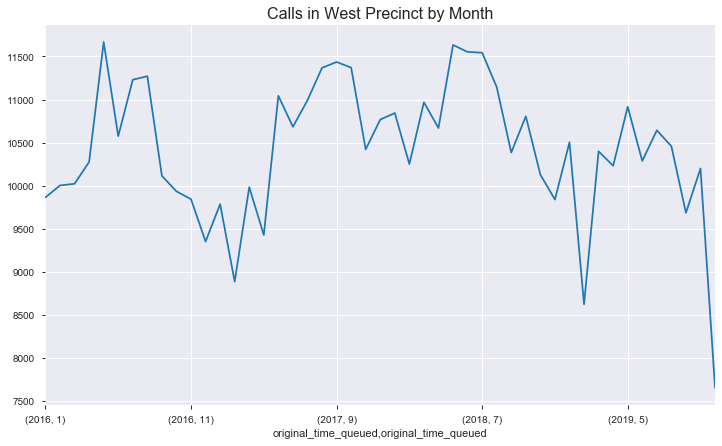

In [386]:
west[west['original_time_queued'].dt.year > 2015].groupby([west['original_time_queued'].dt.year, west['original_time_queued'].dt.month]).size().plot(figsize = (12, 7))
plt.title('Calls in West Precinct by Month', fontsize = 16);

## Now I want to model for the "King" sector in the West Precinct
- Looking at predicting call volumes by day

In [400]:
#subset west df, drop unnecessary columns
king = pd.DataFrame(west[west['sector'] == 'king'][['original_time_queued', 'cad_event_number']])
king.head()

,original_time_queued,cad_event_number
2,2009-06-02 03:47:24,2009000189340
8,2009-06-02 03:58:02,2009000189348
14,2009-06-02 04:10:17,2009000189356
28,2009-06-02 04:44:09,2009000189371
32,2009-06-02 05:00:15,2009000189375


In [401]:
#set index to datetime
king.set_index('original_time_queued', inplace = True)
king.head()

,cad_event_number
original_time_queued,
2009-06-02 03:47:24,2009000189340
2009-06-02 03:58:02,2009000189348
2009-06-02 04:10:17,2009000189356
2009-06-02 04:44:09,2009000189371
2009-06-02 05:00:15,2009000189375


In [402]:
#resample df for rollup of daily call volume
king = pd.DataFrame(king.cad_event_number.resample('d').size())
king.rename(columns = {'cad_event_number':'daily_calls'}, inplace = True)
king.head()

,daily_calls
original_time_queued,
2009-06-02,95
2009-06-03,106
2009-06-04,94
2009-06-05,94
2009-06-06,69


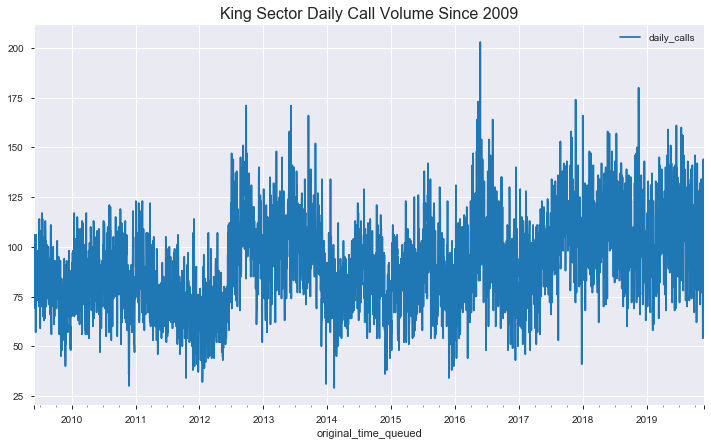

In [403]:
#plot out daily calls for d1 beat in west precinct, looks like the daily calls have been trending down overall, with a spike in 2012
king.plot(figsize = (12, 7))
plt.title('King Sector Daily Call Volume Since 2009', fontsize = 16);

__Rolling Means__
- Now I want to look at plotting the data vs a "rolling mean", which is just the average of whatever window size that you specify
- I am going to play around with several different window sizes to find a good fit for the data

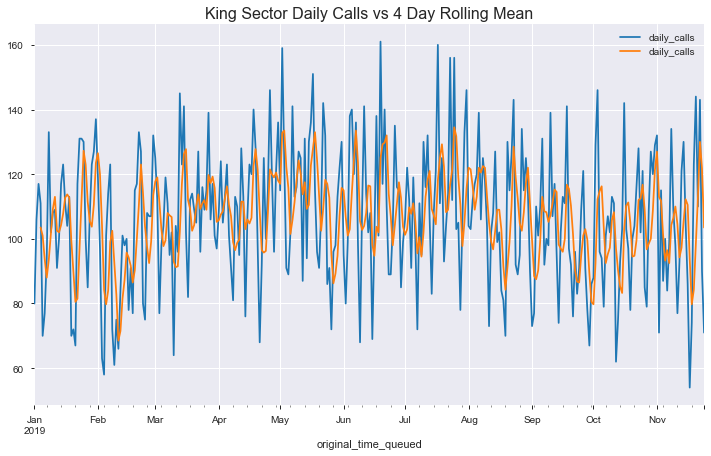

In [462]:
#now look at only data for 2019
king_2019 = king.loc['2019-01-01':, :]

#now plot that data against a rolling mean with a window size of 
king_2019.plot(legend = True, figsize = (12, 7))
plt.title('King Sector Daily Calls vs 4 Day Rolling Mean', fontsize = 16)

#we can make the window ANY size
king_2019.rolling(window = 4).mean()['daily_calls'].plot(legend = True);

__Outlier Removal__
- Removing outliers can increase the quality of a model's predictions significantly, so I will do this and plot the rolling mean again as well

In [407]:
def z_score_indices_of_outliers(X, threshold=3):
    '''
    Detects outliers using Z-score standardization
    
    Input: - X: A feature in your dataset
           - threshold: The number of standard deviations from the mean
                        to be considered an outlier
                        
    Output: A data frame with all outliers beyond 3 standard deviations
    '''
    X_mean = np.mean(X)
    X_stdev = np.std(X)
    z_scores = [(y - X_mean) / X_stdev for y in X]
    z_df = pd.DataFrame(z_scores)
    pos_outliers = z_df[z_df[0] > 3]
    neg_outliers = z_df[z_df[0] < -3]
    return pos_outliers; neg_outliers

In [408]:
#detect outliers
to_drop = z_score_indices_of_outliers(king_2019['daily_calls'], 3)

#remove outliers 
king_2019 = king_2019.reset_index().drop(to_drop.index).set_index('original_time_queued')

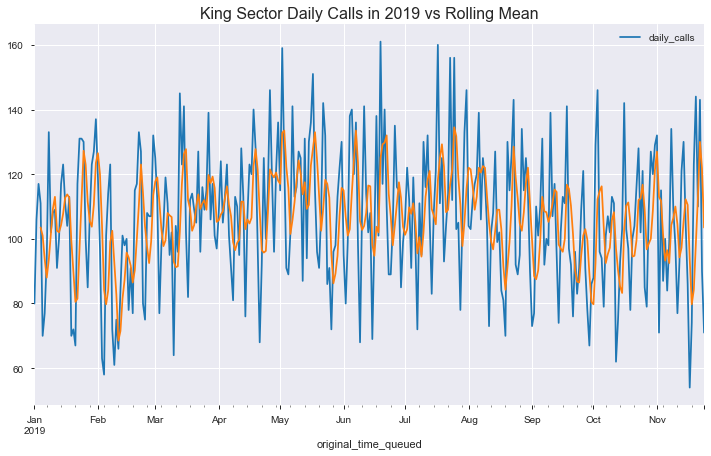

In [409]:
#now plot that data against a rolling mean with a window size of 4 days
king_2019.plot(figsize = (12, 7))
plt.title('King Sector Daily Calls in 2019 vs Rolling Mean', fontsize = 16)

#plot rolling mean, we can see that the rolling mean fits the data a little better than it did with the outliers in place
king_2019.rolling(window = 4).mean()['daily_calls'].plot();

__Finding Overall Trends__
- I am going to use the hodrick-prescott filter to find the overall trend for this beat's call volume
- you can set the filter for windows of data, I am going to use quarterly (by setting lambda value)

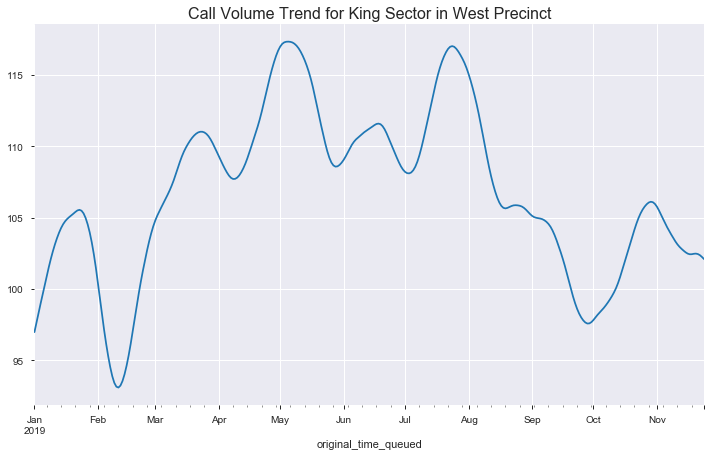

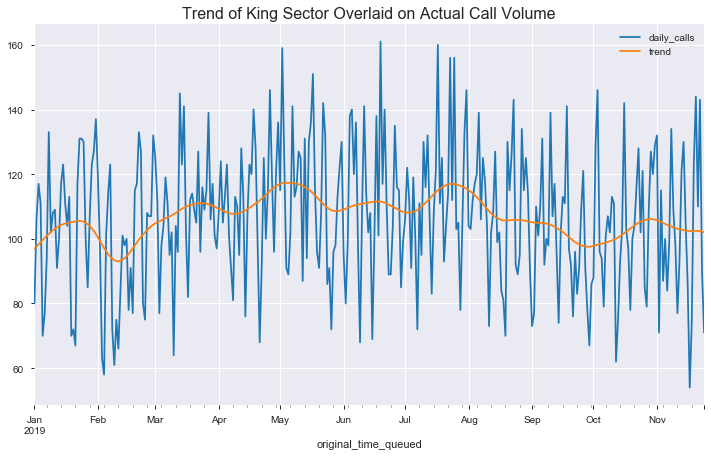

In [410]:
#use statsmodels to get the trend (hodrick-prescott filter)
# tuple unpacking gdp_cycle, gdp_trend
call_cycle, call_trend = hpfilter(king_2019.daily_calls, lamb = 1600)

call_trend.plot(figsize = (12, 7))
plt.title('Call Volume Trend for King Sector in West Precinct', fontsize = 16)

#add trend column to d1_2019 so that we can plot the trend on top of the df
king_2019['trend'] = call_trend

#plot the trend over the data
king_2019[['daily_calls', 'trend']].plot(figsize = (12, 7))
plt.title('Trend of King Sector Overlaid on Actual Call Volume', fontsize = 16);

__ETS Decomposition (Error, Trend, Seasonality)__
- decomposing the data into these subplots shows that there is some seasonality to the data

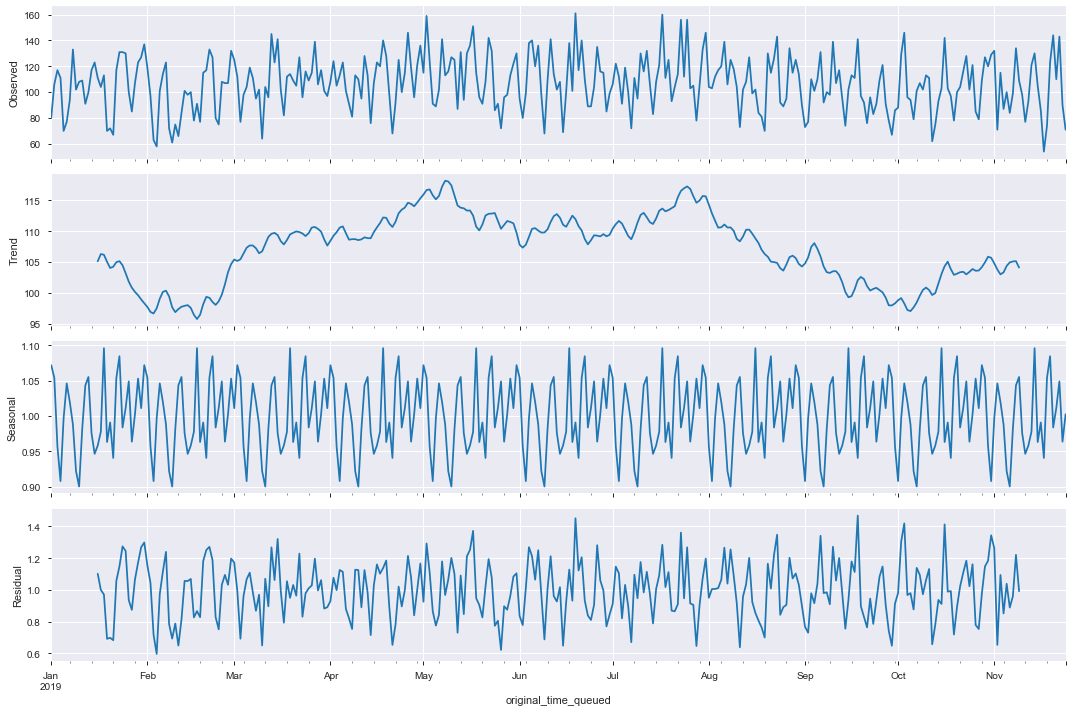

In [434]:
#this is basically separating our data into three different facets, error/seasonality/trend, so we can call those three things as if they are methods of the 
# multiplicative model
results = seasonal_decompose(king_2019['daily_calls'], model = 'multiplicative', freq = 30)

#make plot larger
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10 #specify figsize

results.plot(); #we have to put the ; after the plot for some reason, its weird without it

## Modeling with Autoregression (ARIMA without the integrated moving average) 

__Is this data stationary?__
- I am going to use the augmented dickey-fuller test to determine if the data is in need of differencing to create stationarity
- stationary data is needed for quality predictions in time series modeling

In [412]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [413]:
adf_test(king_2019['daily_calls'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.11
p-value                  0.03
# lags used             13.00
# observations         314.00
critical value (1%)     -3.45
critical value (5%)     -2.87
critical value (10%)    -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [422]:
#split the data in train/test sets
# Set one month for testing
train = king_2019.iloc[:300]
test = king_2019.iloc[300:]

## Fit an AR(p) model where statsmodels chooses p
we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [423]:
model = AR(train['daily_calls'])

#allow statsmodels to choose the maxlag parameter for us rather than iterating through options
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 16
Coefficients:
const             46.81
L1.daily_calls     0.18
L2.daily_calls     0.10
L3.daily_calls    -0.08
L4.daily_calls     0.03
L5.daily_calls     0.02
L6.daily_calls     0.16
L7.daily_calls     0.15
L8.daily_calls    -0.05
L9.daily_calls    -0.05
L10.daily_calls   -0.05
L11.daily_calls   -0.06
L12.daily_calls   -0.09
L13.daily_calls    0.01
L14.daily_calls    0.32
L15.daily_calls    0.06
L16.daily_calls   -0.09
dtype: float64


In [425]:
#obtaining predictions from the model with a window of aroudn 25 days at the end of the data for testing
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions16 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

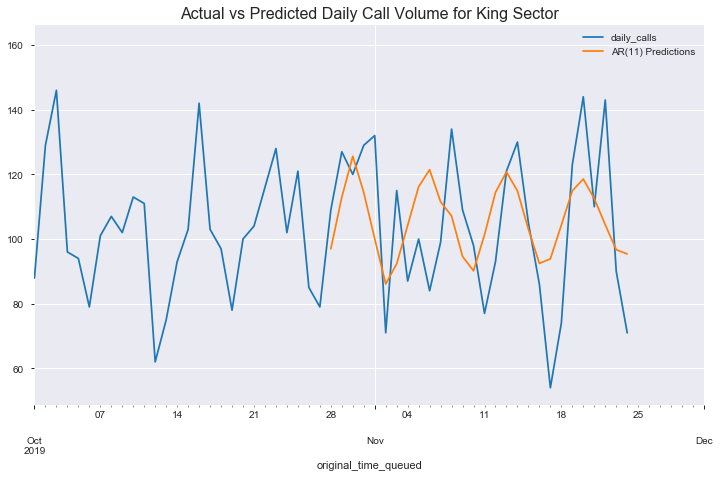

In [440]:
#plot the predictions
king_2019['daily_calls'].plot(legend = True)
predictions16.plot(legend = True, figsize = (12, 7))
plt.title('Actual vs Predicted Daily Call Volume for King Sector', fontsize = 16)
plt.xlim('2019-10-01', '2019-12-01');

## Evaluate the Model's Performance
- I am going to use RMSE to get error terms in the units of the original variable, which is calls per day

In [448]:
#compare multiple models with this code
# labels = ['AR(11)']
# preds = [predictions16] 

# for i in range(1):
#     error = np.sqrt(mean_squared_error(test['daily_calls'], preds[i]))
#     print(f'{labels[i]} Error: {error:11.10}')

print(f"Autoregression Model RMSE: {np.sqrt(mean_squared_error(test['daily_calls'], predictions16))} Calls Per Day")

Autoregression Model RMSE: 20.818338470846285 Calls Per Day


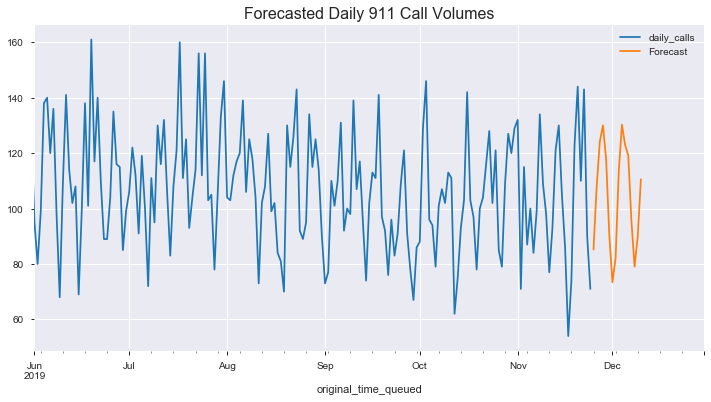

In [459]:
#predict future calls with model now
# First, retrain the model on the full dataset
model = AR(king_2019['daily_calls'])

# Next, fit the model
ARfit = model.fit(maxlag=16,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(king_2019), end=len(king_2019)+15, dynamic=False).rename('Forecast')

# Plot the results
king_2019['daily_calls'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6))
plt.title('Forecasted Daily 911 Call Volumes', fontsize = 16)
plt.xlim('2019-06-01', '2019-12-30');

In [460]:
fcast

2019-11-25    85.24
2019-11-26   107.89
2019-11-27   124.19
2019-11-28   130.04
2019-11-29   117.83
2019-11-30    90.40
2019-12-01    73.40
2019-12-02    82.22
2019-12-03   113.43
2019-12-04   130.30
2019-12-05   122.98
2019-12-06   119.21
2019-12-07    95.62
2019-12-08    79.02
2019-12-09    89.84
2019-12-10   110.56
Freq: D, Name: Forecast, dtype: float64